In [1]:
import numpy as np
import torch
import sys
from utils_old import *
import utils
from matplotlib import pyplot as plt
import torch.nn as nn
import time
from numba import cuda
from tqdm import tqdm, trange
import os
import pyroc
import pandas as pd
import gc
from IPython.display import clear_output
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="4"  
device = torch.device("cuda:0")
dtype = torch.float32
torch.manual_seed(42)
np.random.seed(42)

/math/home/eruisun/software/anaconda/envs/LFI/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

H = 500
out= 100
L = 1
class DN(torch.nn.Module):
    def __init__(self, H=300, out=100):
        super(DN, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, out, bias=True),
        )
    def forward(self, input):
        output = self.model(input)
        return output

class another_DN(torch.nn.Module):
    def __init__(self, H=300, out=100):
        super(another_DN, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.Tanh(),
            torch.nn.Linear(H, 28, bias=True),
        )
    def forward(self, input):
        output = self.model(input) + input
        return output

class Classifier(torch.nn.Module):
    def __init__(self, H=300, layers = 5, tanh=False):
        super(Classifier, self).__init__()
        self.restored = False
        self.model = torch.nn.Sequential(
            torch.nn.Linear(28, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, H, bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(H, 1, bias=True),
            torch.nn.Sigmoid(),
        )
        if layers == 6:
            self.model = torch.nn.Sequential(
                torch.nn.Linear(28, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.ReLU(),
                torch.nn.Linear(H, 1, bias=True),
                torch.nn.Sigmoid(),
            )
        if tanh:
            self.model = torch.nn.Sequential(
                torch.nn.Linear(28, H, bias=True),
                torch.nn.Tanh(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.Tanh(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.Tanh(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.Tanh(),
                torch.nn.Linear(H, H, bias=True),
                torch.nn.Tanh(),
                torch.nn.Linear(H, 1, bias=True),
                torch.nn.Sigmoid()
            )
    def forward(self, input):
        output = self.model(input)
        return output

In [3]:
dataset = np.load('HIGGS.npy')
dataset_P = dataset[dataset[:,0]==0][:, 1:] # background (5829122, 28)
dataset_Q = dataset[dataset[:,0]==1][:, 1:] # signal     (5170877, 28)
# dataset_P = MatConvert(dataset_P, device=device, dtype=dtype)
# dataset_Q = MatConvert(dataset_Q, device=device, dtype=dtype)

In [4]:
n_train = 130000
n_eval = 10000

In [5]:
path_LFI = './checkpoint3000/30/'
path_Fea_G = './Fea_Gau/checkpoint30000/30/'
path_Gaussian = './Gaussian/checkpoint3000/800/'
path_Scheffe = './Scheffe/checkpoint1300100/120/'

path_dict_roc = {
    'MMD-L': path_LFI,
    'MMD-G': path_Fea_G,
    'MMD-O': path_Gaussian,
    'Scheffe': path_Scheffe,
}

# Define Class

In [6]:
# 必须手算!
n = 1300000
n_eval = 10000
def generate_PQ(n_eval, Samples, batch_size, If_n_large_MonteCarlo,
                    model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst,
                    dataset_P, dataset_Q, only_scores=False):
    if only_scores:
        X_eval = dataset_P[np.random.choice(dataset_P.shape[0], n_eval, replace=False)]
        Y_eval = dataset_Q[np.random.choice(dataset_Q.shape[0], n_eval, replace=False)]
        batches = (Samples-1)//batch_size + 1
        P_scores = np.zeros(Samples)
        Q_scores = np.zeros(Samples)
        for i in trange(batches):
            remain = batch_size
            if i==batches-1:
                remain = Samples - batch_size*(batches-1)
            S_hand = np.concatenate((dataset_P[np.random.choice(dataset_P.shape[0], remain, replace=False)],
                        dataset_Q[np.random.choice(dataset_Q.shape[0], remain, replace=False)]), axis=0)
            S_hand = MatConvert(S_hand, device, dtype)
            PQhat_hand = compute_score_func(S_hand, X_eval, Y_eval, 
                        model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst,
                        M = n_eval)
            PQhat_hand = PQhat_hand.cpu().detach().numpy()
            try:
                P_scores[i*batch_size: i*batch_size+remain] = PQhat_hand[:remain]
                Q_scores[i*batch_size: i*batch_size+remain] = PQhat_hand[remain:]
            except:
                P_scores[i*batch_size: i*batch_size+remain] = PQhat_hand[:remain,0]
                Q_scores[i*batch_size: i*batch_size+remain] = PQhat_hand[remain:,0]
        return X_eval, Y_eval, P_scores, Q_scores, None, None, None
    else:
        X_eval = dataset_P[np.random.choice(dataset_P.shape[0], n_eval, replace=False)]
        Y_eval = dataset_Q[np.random.choice(dataset_Q.shape[0], n_eval, replace=False)]
        EKxx, EKyy, EKxy = compute_gamma(X_eval, Y_eval, model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst, MonteCarlo=If_n_large_MonteCarlo)
        # 算定下来X_eval, Y_eval之后phi的真实的分布
        batches = (Samples-1)//batch_size + 1
        P_scores = np.zeros(Samples)
        Q_scores = np.zeros(Samples)
        for i in trange(batches):
            remain = batch_size
            if i==batches-1:
                remain = Samples - batch_size*(batches-1)
            S_hand = np.concatenate((dataset_P[np.random.choice(dataset_P.shape[0], remain, replace=False)],
                        dataset_Q[np.random.choice(dataset_Q.shape[0], remain, replace=False)]), axis=0)
            S_hand = MatConvert(S_hand, device, dtype)
            PQhat_hand = compute_score_func(S_hand, X_eval, Y_eval, 
                        model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst,
                        M = n_eval)
            PQhat_hand = PQhat_hand.cpu().detach().numpy()
            try:
                P_scores[i*batch_size: i*batch_size+remain] = PQhat_hand[:remain]
                Q_scores[i*batch_size: i*batch_size+remain] = PQhat_hand[remain:]
            except:
                P_scores[i*batch_size: i*batch_size+remain] = PQhat_hand[:remain,0]
                Q_scores[i*batch_size: i*batch_size+remain] = PQhat_hand[remain:,0]
        return X_eval, Y_eval, P_scores, Q_scores, EKxx, EKyy, EKxy


In [7]:
# 注意P_scores, Q_scores已经考虑到n_eval贡献的方差
# EKxx, EKyy, EKxy完全是n_eval决定
class PQ_data():
    def __init__(self, P_scores, Q_scores, EKxx, EKyy, EKxy):
        self.P_scores = P_scores
        self.Q_scores = Q_scores
        self.P_mean = np.mean(P_scores)
        self.P_std = np.std(P_scores)
        self.Q_mean = np.mean(Q_scores)
        self.Q_std = np.std(Q_scores)
        self.EKxx = EKxx
        self.EKyy = EKyy
        self.EKxy = EKxy
        self.gamma = None
    def pval_T_m_in_sigma(self, pi, m, use_gaussian, MonteCarlo):
        T = pi*self.Q_mean + (1-pi)*self.P_mean
        # use_gaussian: 是否用高斯近似, 0是用MonteCarlo近似，1是用高斯近似
        P_scores = self.P_scores
        mean = self.P_mean
        std = self.P_std
        if m==1:
            p = np.mean(P_scores > T)
            p = -scipy.stats.norm.ppf(p)
        if use_gaussian:
            p = (T-mean)/std*np.sqrt(m)
        else:
            T_mix_MonteCarlo_list = np.zeros(MonteCarlo)
            for i in range(MonteCarlo):
                idx = np.random.choice(P_scores.shape[0], m, replace=False)
                T_mix_MonteCarlo_list[i] = np.mean(P_scores[idx])
            p = np.mean(T_mix_MonteCarlo_list > T)
            p = -scipy.stats.norm.ppf(p)
        self.p = p
        return p
    def type_1_error_H0(self, pi, m, use_gaussian, MonteCarlo, estimate_gamma = False):
        if estimate_gamma == False:
            P_scores = self.P_scores
            Q_scores = self.Q_scores
            mean = self.P_mean
            std = self.P_std
            gamma = self.EKxx*(pi/2-1) + self.EKxy*(1-pi) + self.EKyy*(pi/2)
            self.gamma = gamma
            if m==1:
                type_1_error = np.mean(P_scores > gamma)
            if use_gaussian:
                type_1_error = 1-scipy.stats.norm.cdf((gamma-mean)/std*np.sqrt(m))
            else:
                MonteCarlo_list = np.zeros(MonteCarlo)
                for i in range(MonteCarlo):
                    idx = np.random.choice(P_scores.shape[0], m, replace=False)
                    MonteCarlo_list[i] = np.mean(P_scores[idx])
                type_1_error = np.mean(MonteCarlo_list > gamma)
            self.type_1_error = type_1_error
            return type_1_error
        else:
            P_scores = self.P_scores
            Q_scores = self.Q_scores
            mean = self.P_mean
            std = self.P_std
            P_mean = self.P_mean
            Q_mean = self.Q_mean
            gamma = pi/2*Q_mean + (1-pi/2)*P_mean
            if m==1:
                type_1_error = np.mean(P_scores > gamma)
            if use_gaussian:
                type_1_error = 1-scipy.stats.norm.cdf((gamma-mean)/std*np.sqrt(m))
            else:
                MonteCarlo_list = np.zeros(MonteCarlo)
                for i in range(MonteCarlo):
                    idx = np.random.choice(P_scores.shape[0], m, replace=False)
                    MonteCarlo_list[i] = np.mean(P_scores[idx])
                type_1_error = np.mean(MonteCarlo_list > gamma)
            self.type_1_error = type_1_error
            return type_1_error
    def type_2_error_H1(self, pi, m, use_gaussian, MonteCarlo, estimate_gamma = False):
        if estimate_gamma == False:
            P_scores = self.P_scores
            Q_scores = self.Q_scores
            P_mean = self.P_mean
            P_std = self.P_std
            Q_mean = self.Q_mean
            Q_std = self.Q_std
            gamma = self.EKxx*(pi/2-1) + self.EKxy*(1-pi) + self.EKyy*(pi/2)
            self.gamma = gamma
            if m==1:
                type_2_error = np.mean(Q_scores < gamma)
            if use_gaussian:
                mean = Q_mean*pi + P_mean*(1-pi)
                std = np.sqrt(pi*Q_std**2 + (1-pi)*P_std**2)
                type_2_error = scipy.stats.norm.cdf((gamma-mean)/std*np.sqrt(m))
            else:
                MonteCarlo_list = np.zeros(MonteCarlo)
                for i in range(MonteCarlo):
                    Signals_idx = np.random.choice(Q_scores.shape[0], int(m*pi), replace=False)
                    Backgrounds_idx = np.random.choice(P_scores.shape[0], int(m*(1-pi)), replace=False)
                    MonteCarlo_list[i] = np.mean(np.concatenate((Q_scores[Signals_idx], P_scores[Backgrounds_idx])))
                type_2_error = np.mean(MonteCarlo_list < gamma)
            self.type_2_error = type_2_error
            return type_2_error
        else:
            P_scores = self.P_scores
            Q_scores = self.Q_scores
            P_mean = self.P_mean
            P_std = self.P_std
            Q_mean = self.Q_mean
            Q_std = self.Q_std
            gamma = pi/2*Q_mean + (1-pi/2)*P_mean
            if m==1:
                type_2_error = np.mean(Q_scores < gamma)
            if use_gaussian:
                mean = Q_mean*pi + P_mean*(1-pi)
                std = np.sqrt(pi*Q_std**2 + (1-pi)*P_std**2)
                type_2_error = scipy.stats.norm.cdf((gamma-mean)/std*np.sqrt(m))
            else:
                MonteCarlo_list = np.zeros(MonteCarlo)
                for i in range(MonteCarlo):
                    Signals_idx = np.random.choice(Q_scores.shape[0], int(m*pi), replace=False)
                    Backgrounds_idx = np.random.choice(P_scores.shape[0], int(m*(1-pi)), replace=False)
                    MonteCarlo_list[i] = np.mean(np.concatenate((Q_scores[Signals_idx], P_scores[Backgrounds_idx])))
                type_2_error = np.mean(MonteCarlo_list < gamma)
            self.type_2_error = type_2_error
            return type_2_error

# Draw pval-m

In [8]:
path_LFI = './checkpoint1300101/30/'
path_Fea_G = './Fea_Gau/checkpoint1300000/30/'
path_Gaussian = './Gaussian/checkpoint1299999/800/'
path_Scheffe = './Scheffe/checkpoint1300100/120/'

path_dict_roc = {
    'MMD-L': path_LFI,
    'MMD-G': path_Fea_G,
    'MMD-O': path_Gaussian,
    'Scheffe': path_Scheffe,
}
ms = [10, 30, 60, 100, 200, 400, 600, 800, 1000]

## Soft

In [9]:
# 全部是软的：
p_gau_list_L = np.zeros(len(ms))
p_monte_list_L = np.zeros(len(ms))
p_gau_list_G = np.zeros(len(ms))
p_monte_list_G = np.zeros(len(ms))
p_gau_list_O = np.zeros(len(ms))
p_monte_list_O = np.zeros(len(ms))
p_gau_list_S = np.zeros(len(ms))
p_monte_list_S = np.zeros(len(ms))    


In [10]:
for i, key in enumerate(tqdm(path_dict_roc)):
    path = path_dict_roc[key]
    Samples = 10000
    batch_size = 10000
    If_n_large_MonteCarlo = 100
    if key == 'Scheffe':
        model = Classifier(300, 6, True).to(device)
    if key == 'MMD-O':
        model = DN(300, 100).to(device)
    if key == 'MMD-L':
        model = DN(300, 100).to(device)
    if key == 'MMD-G':
        model = DN(300, 100).to(device)
    another_model = another_DN().to(device)
    model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst = load_model(model, another_model, path)
    X_eval, Y_eval, P_scores, Q_scores, _,_,_ = generate_PQ(n_eval, Samples, batch_size, If_n_large_MonteCarlo,
                                                                    model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst,
                                                                    dataset_P, dataset_Q, only_scores=True)
    My_class = PQ_data(P_scores, Q_scores, None, None, None)
    for j, m in enumerate(ms):
        p_gau = My_class.pval_T_m_in_sigma(0.1, m, use_gaussian=True, MonteCarlo=0)
        p_monte = My_class.pval_T_m_in_sigma(0.1, m, use_gaussian=False, MonteCarlo=1000)
        if key == 'Scheffe':
            p_gau_list_S[j] = p_gau
            p_monte_list_S[j] = p_monte
        if key == 'MMD-O':
            p_gau_list_O[j] = p_gau
            p_monte_list_O[j] = p_monte
        if key == 'MMD-L':
            p_gau_list_L[j] = p_gau
            p_monte_list_L[j] = p_monte
        if key == 'MMD-G':
            p_gau_list_G[j] = p_gau
            p_monte_list_G[j] = p_monte

 25%|██▌       | 1/4 [00:05<00:15,  5.32s/it]

Fea_Gau


 50%|█████     | 2/4 [00:08<00:08,  4.29s/it]

Gaussian


 75%|███████▌  | 3/4 [00:12<00:03,  3.94s/it]

Scheffe


100%|██████████| 4/4 [00:15<00:00,  3.95s/it]


## Hard

In [11]:
# 全部是硬的：
p_gau_list_L_hard = np.zeros(len(ms))
p_monte_list_L_hard = np.zeros(len(ms))
p_gau_list_G_hard = np.zeros(len(ms))
p_monte_list_G_hard = np.zeros(len(ms))
p_gau_list_O_hard = np.zeros(len(ms))
p_monte_list_O_hard = np.zeros(len(ms))
p_gau_list_S_hard = np.zeros(len(ms))
p_monte_list_S_hard = np.zeros(len(ms))

In [12]:
for i, key in enumerate(tqdm(path_dict_roc)):
    path = path_dict_roc[key]
    Samples = 10000
    batch_size = 10000
    If_n_large_MonteCarlo = 100
    if key == 'Scheffe':
        model = Classifier(300, 6, True).to(device)
    if key == 'MMD-O':
        model = DN(300, 100).to(device)
    if key == 'MMD-L':
        model = DN(300, 100).to(device)
    if key == 'MMD-G':
        model = DN(300, 100).to(device)
    another_model = another_DN().to(device)
    model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst = load_model(model, another_model, path)
    n_eval = 10000
    X_eval, Y_eval, P_scores, Q_scores, _,_,_ = generate_PQ(n_eval, Samples, batch_size, If_n_large_MonteCarlo,
                                                                    model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst,
                                                                    dataset_P, dataset_Q, only_scores=True)
    PQhat = np.concatenate((P_scores, Q_scores), axis=0)                                                                
    thres = get_thres(PQhat)
    for j, m in enumerate(ms):
        p_gau = get_thres_pval(PQhat, thres, 0.1, m)
        if key == 'Scheffe':
            p_gau_list_S_hard[j] = p_gau
        if key == 'MMD-O':
            p_gau_list_O_hard[j] = p_gau
        if key == 'MMD-L':
            p_gau_list_L_hard[j] = p_gau
        if key == 'MMD-G':
            p_gau_list_G_hard[j] = p_gau
    clear_output()

100%|██████████| 4/4 [00:41<00:00, 10.32s/it]


In [13]:
p_S_05 = np.zeros(len(ms))
path = path_dict_roc['Scheffe']
Samples = 10000
batch_size = 10000
If_n_large_MonteCarlo = 100
model = Classifier(300, 6, True).to(device)
another_model = another_DN().to(device)
model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst = load_model(model, another_model, path)
n_eval = 10000
X_eval, Y_eval, P_scores, Q_scores, _,_,_ = generate_PQ(n_eval, Samples, batch_size, If_n_large_MonteCarlo,
                                                                model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst,
                                                                dataset_P, dataset_Q, only_scores=True)
PQhat = np.concatenate((P_scores, Q_scores), axis=0)                                                                
thres = 1/2
p_gau = get_thres_pval(PQhat, thres)
for j, m in enumerate(ms):
    p_gau = My_class.pval_T_m_in_sigma(0.1, m, use_gaussian=True, MonteCarlo=0)
    if key == 'Scheffe':
        p_S_05[j] = p_gau


Scheffe


100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

test max: 0.999796450138092 test min: 0.00010214759095106274
0.7871 0.7571
a: 0.7871 , b: 0.7571 , E: 321.61


## Plot

Text(0.5, 0.98, '$\\pi$=0.1')

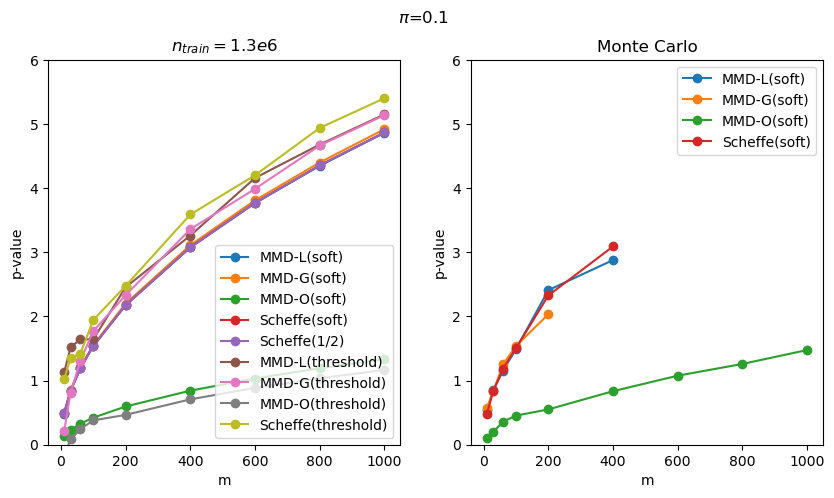

In [14]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(ms, p_gau_list_L, label='MMD-L(soft)', marker='o')
plt.plot(ms, p_gau_list_G, label='MMD-G(soft)', marker='o')
plt.plot(ms, p_gau_list_O, label='MMD-O(soft)', marker='o')
plt.plot(ms, p_gau_list_S, label='Scheffe(soft)', marker='o')
plt.plot(ms, p_S_05, label='Scheffe(1/2)', marker='o')
plt.plot(ms, p_gau_list_L_hard, label='MMD-L(threshold)', marker='o')
plt.plot(ms, p_gau_list_G_hard, label='MMD-G(threshold)', marker='o')
plt.plot(ms, p_gau_list_O_hard, label='MMD-O(threshold)', marker='o')
plt.plot(ms, p_gau_list_S_hard, label='Scheffe(threshold)', marker='o')
plt.title('$n_{train}=1.3e6$')
plt.xlabel('m')
plt.ylabel('p-value')
plt.legend()
plt.ylim(0,6)

plt.subplot(1,2,2)  
plt.plot(ms, p_monte_list_L, label='MMD-L(soft)', marker='o')
plt.plot(ms, p_monte_list_G, label='MMD-G(soft)', marker='o')
plt.plot(ms, p_monte_list_O, label='MMD-O(soft)', marker='o')
plt.plot(ms, p_monte_list_S, label='Scheffe(soft)', marker='o')
plt.title('Monte Carlo')
plt.xlabel('m')
plt.ylabel('p-value')
plt.legend()
plt.ylim(0,6)

plt.suptitle('$\pi$=0.1')


# Type 1, 2 error

In [15]:
def calculate_type1_error(a, b, m, pi, gamma):
    ET_H1 = pi*m*a+(1-pi)*m*(1-b)
    ET_H0 = m*(1-b)
    return 1- scipy.stats.binom.cdf(gamma, m, 1-b)
def calculate_type2_error(a, b, m, pi, gamma):
    ET_H1 = pi*m*a+(1-pi)*m*(1-b)
    ET_H0 = m*(1-b)
    return scipy.stats.binom.cdf(gamma, m, pi*a+(1-pi)*(1-b))
ms = np.array([10, 50, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100])
#ms = np.array([100, 300, 500, 700, 900, 1100])
n_eval = 10000
pi = 1/11
repeats = 10

In [16]:
path_LFI = './checkpoint1300101/30/'
path_Fea_G = './Fea_Gau/checkpoint1300000/30/'
path_Gaussian = './Gaussian/checkpoint1299999/800/'
path_Scheffe = './Scheffe/checkpoint1300100/120/'

path_dict_roc = {
    'MMD-L': path_LFI,
    'MMD-G': path_Fea_G,
    'MMD-O': path_Gaussian,
    'Scheffe': path_Scheffe,
}
type1_error_dict = {
    'MMD-L(soft)': np.zeros((len(ms), repeats)),
    'MMD-G(soft)': np.zeros((len(ms), repeats)),
    'MMD-O(soft)': np.zeros((len(ms), repeats)),
    'Scheffe(soft)': np.zeros((len(ms), repeats)),
    'MMD-L(threshold)': np.zeros((len(ms), repeats)),
    'MMD-G(threshold)': np.zeros((len(ms), repeats)),
    'MMD-O(threshold)': np.zeros((len(ms), repeats)),
    'Scheffe(threshold)': np.zeros((len(ms), repeats)),
    'Scheffe(1/2)': np.zeros((len(ms), repeats)),
}
type2_error_dict = {
    'MMD-L(soft)': np.zeros((len(ms), repeats)),
    'MMD-G(soft)': np.zeros((len(ms), repeats)),
    'MMD-O(soft)': np.zeros((len(ms), repeats)),
    'Scheffe(soft)': np.zeros((len(ms), repeats)),
    'MMD-L(threshold)': np.zeros((len(ms), repeats)),
    'MMD-G(threshold)': np.zeros((len(ms), repeats)),
    'MMD-O(threshold)': np.zeros((len(ms), repeats)),
    'Scheffe(threshold)': np.zeros((len(ms), repeats)),
    'Scheffe(1/2)': np.zeros((len(ms), repeats)),
}

for i, key in enumerate(tqdm(path_dict_roc)):
    path = path_dict_roc[key]
    Samples = 10000
    batch_size = 10000
    If_n_large_MonteCarlo = 100
    if key == 'Scheffe':
        model = Classifier(300, 6, True).to(device)
    if key == 'MMD-O':
        model = DN(300, 100).to(device)
    if key == 'MMD-L':
        model = DN(300, 100).to(device)
    if key == 'MMD-G':
        model = DN(300, 100).to(device)
    another_model = another_DN().to(device)
    model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst = load_model(model, another_model, path)
    for k in range(repeats):
        X_eval, Y_eval, P_scores, Q_scores, EKxx, EKyy, EKxy = generate_PQ(n_eval, Samples, batch_size, If_n_large_MonteCarlo,
                                                                        model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst,
                                                                        dataset_P[n:], dataset_Q[n:], only_scores=False)
        My_class  = PQ_data(P_scores, Q_scores, EKxx, EKyy, EKxy)
        PQhat = np.concatenate((P_scores, Q_scores), axis=0)      
        #thres = get_thres(PQhat)
        print('--------------------')
        print('thres=', thres)
        X_eval = MatConvert(X_eval, dtype=dtype, device=device)
        Y_eval = MatConvert(Y_eval, dtype=dtype, device=device)
        thres,a_th,b_th = utils.get_thres_at_once(X_eval, Y_eval, X_eval, Y_eval, 
                        model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst)
        print('thres=', thres)
        print(i, key, thres)
        a = np.mean(Q_scores>thres).item() # sig->sig
        b = np.mean(P_scores<thres).item() # bkg->bkg
        print(a, b)
        print('--------------------')
        for j, m in enumerate(ms):
            gamma = pi/2*m*a_th+(1-pi/2)*m*(1-b_th)
            type1_error_dict[key+'(threshold)'][j,k] = calculate_type1_error(a, b, m, pi, gamma)
            type2_error_dict[key+'(threshold)'][j,k] = calculate_type2_error(a, b, m, pi, gamma)
        aa = np.mean(Q_scores>1/2).item() # sig->sig
        bb = np.mean(P_scores<1/2).item() # bkg->bkg
        print('---------------')
        for j, m in enumerate(ms):
            if key != 'Scheffe':
                type1_error_dict[key+'(soft)'][j,k] = My_class.type_1_error_H0(pi, m, use_gaussian=False, MonteCarlo=1000)
                type2_error_dict[key+'(soft)'][j,k] = My_class.type_2_error_H1(pi, m, use_gaussian=False, MonteCarlo=1000)
            if key == 'Scheffe':
                gamma = pi/2*m*aa+(1-pi/2)*m*(1-bb)
                type1_error_dict[key+'(1/2)'][j,k] = calculate_type1_error(aa, bb, m, pi, gamma)
                type2_error_dict[key+'(1/2)'][j,k] = calculate_type2_error(aa, bb, m, pi, gamma)
                type1_error_dict[key+'(soft)'][j,k] = My_class.type_1_error_H0(pi, m, use_gaussian=False, MonteCarlo=1000, estimate_gamma=True)
                type2_error_dict[key+'(soft)'][j,k] = My_class.type_2_error_H1(pi, m, use_gaussian=False, MonteCarlo=1000, estimate_gamma=True)
                
            #
            clear_output()
            print(k)

100%|██████████| 4/4 [08:08<00:00, 122.07s/it]

9


In [17]:
# read
# error_sum_LFI_soft = np.load('error_sum_LFI_soft.npy')
# error_sum_Fea_Gau_soft = np.load('error_sum_Fea_Gau_soft.npy')
# error_sum_Gaussian_soft = np.load('error_sum_Gaussian_soft.npy')
# error_sum_LBI_soft = np.load('error_sum_LBI_soft.npy')
# error_sum_LFI_threshold = np.load('error_sum_LFI_threshold.npy')
# error_sum_Fea_Gau_threshold = np.load('error_sum_Fea_Gau_threshold.npy')
# error_sum_Gaussian_threshold = np.load('error_sum_Gaussian_threshold.npy')
# error_sum_LBI_threshold = np.load('error_sum_LBI_threshold.npy')
# error_sum_LBI_1_2 = np.load('error_sum_LBI_1_2.npy')


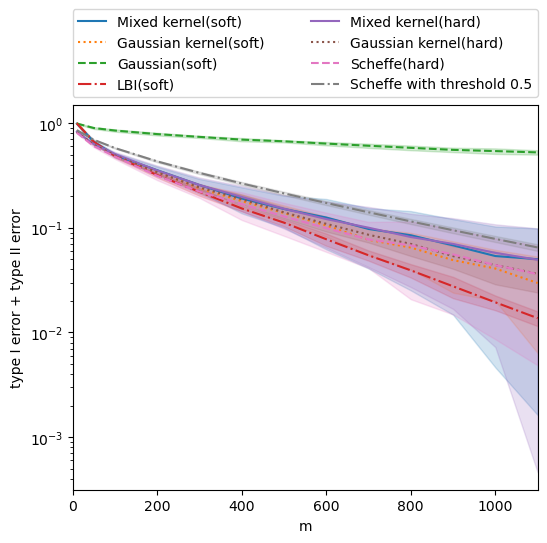

In [18]:
# plt.figure(figsize=(18,5))
# plt.subplot(1,3,1)
# plt.title('Type 1 error')
# plt.plot(ms, type1_error_dict['MMD-L(soft)'], label='MMD-L(soft)', marker='o', linewidth=4)
# plt.plot(ms, type1_error_dict['MMD-G(soft)'], label='MMD-G(soft)', marker='o')
# plt.plot(ms, type1_error_dict['MMD-O(soft)'], label='MMD-O(soft)', marker='o')
# plt.plot(ms, type1_error_dict['Scheffe(soft)'], label='Scheffe(soft)', marker='o', linestyle='--')
# plt.plot(ms, type1_error_dict['MMD-L(threshold)'], label='MMD-L(threshold)', marker='o')
# plt.plot(ms, type1_error_dict['MMD-G(threshold)'], label='MMD-G(threshold)', marker='o')
# plt.plot(ms, type1_error_dict['MMD-O(threshold)'], label='MMD-O(threshold)', marker='o')
# plt.plot(ms, type1_error_dict['Scheffe(threshold)'], label='Scheffe(threshold)', marker='o', linestyle='--')
# plt.plot(ms, type1_error_dict['Scheffe(1/2)'], label='Scheffe(1/2)', marker='o', linestyle='--')
# plt.legend()
# plt.xlabel('m')
# plt.ylabel('Type 1 error')

# plt.subplot(1,3,2)
# plt.title('Type 2 error')
# plt.plot(ms, type2_error_dict['MMD-L(soft)'], label='MMD-L(soft)', marker='o', linewidth=4)
# plt.plot(ms, type2_error_dict['MMD-G(soft)'], label='MMD-G(soft)', marker='o')
# plt.plot(ms, type2_error_dict['MMD-O(soft)'], label='MMD-O(soft)', marker='o')
# plt.plot(ms, type2_error_dict['Scheffe(soft)'], label='Scheffe(soft)', marker='o', linestyle='--')
# plt.plot(ms, type2_error_dict['MMD-L(threshold)'], label='MMD-L(threshold)', marker='o')
# plt.plot(ms, type2_error_dict['MMD-G(threshold)'], label='MMD-G(threshold)', marker='o')
# plt.plot(ms, type2_error_dict['MMD-O(threshold)'], label='MMD-O(threshold)', marker='o')
# plt.plot(ms, type2_error_dict['Scheffe(threshold)'], label='Scheffe(threshold)', marker='o', linestyle='--')
# plt.plot(ms, type2_error_dict['Scheffe(1/2)'], label='Scheffe(1/2)', marker='o', linestyle='--')
# plt.legend()
# plt.xlabel('m')
# plt.ylabel('Type 2 error')

#plt.subplot(1,3,3)
#plt.title('Error sum')
fig = plt.figure(figsize=(6,5))
error_sum_LFI_soft = type1_error_dict['MMD-L(soft)']+type2_error_dict['MMD-L(soft)']
error_sum_Fea_Gau_soft = type1_error_dict['MMD-G(soft)']+type2_error_dict['MMD-G(soft)']
error_sum_Gaussian_soft = type1_error_dict['MMD-O(soft)']+type2_error_dict['MMD-O(soft)']
error_sum_LBI_soft = type1_error_dict['Scheffe(soft)']+type2_error_dict['Scheffe(soft)']
error_sum_LFI_threshold = type1_error_dict['MMD-L(threshold)']+type2_error_dict['MMD-L(threshold)']
error_sum_Fea_Gau_threshold = type1_error_dict['MMD-G(threshold)']+type2_error_dict['MMD-G(threshold)']
error_sum_Gaussian_threshold = type1_error_dict['MMD-O(threshold)']+type2_error_dict['MMD-O(threshold)']
error_sum_LBI_threshold = type1_error_dict['Scheffe(threshold)']+type2_error_dict['Scheffe(threshold)']
error_sum_LBI_1_2 = type1_error_dict['Scheffe(1/2)']+type2_error_dict['Scheffe(1/2)']
# np.save('./error_curve/error_sum_LFI_soft', error_sum_LFI_soft)
# np.save('./error_curve/error_sum_Fea_Gau_soft', error_sum_Fea_Gau_soft)
# np.save('./error_curve/error_sum_Gaussian_soft', error_sum_Gaussian_soft)
# np.save('./error_curve/error_sum_LBI_soft', error_sum_LBI_soft)
# np.save('./error_curve/error_sum_LFI_threshold', error_sum_LFI_threshold)
# np.save('./error_curve/error_sum_Fea_Gau_threshold', error_sum_Fea_Gau_threshold)
# np.save('./error_curve/error_sum_Gaussian_threshold', error_sum_Gaussian_threshold)
# np.save('./error_curve/error_sum_LBI_threshold', error_sum_LBI_threshold)
# np.save('./error_curve/error_sum_LBI_1_2', error_sum_LBI_1_2)

plt.plot(ms, np.mean(error_sum_LFI_soft, axis=1) , label='Mixed kernel(soft)', 
                color='C0', linestyle='-')
plt.fill_between(ms, np.mean(error_sum_LFI_soft, axis=1)-np.std(error_sum_LFI_soft, axis=1), np.mean(error_sum_LFI_soft, axis=1)+np.std(error_sum_LFI_soft, axis=1), 
                alpha=0.2, color='C0')

plt.plot(ms, np.mean(error_sum_Fea_Gau_soft, axis=1), label='Gaussian kernel(soft)', 
                color='C1', linestyle=':')
plt.fill_between(ms, np.mean(error_sum_Fea_Gau_soft, axis=1)-np.std(error_sum_Fea_Gau_soft, axis=1), np.mean(error_sum_Fea_Gau_soft, axis=1)+np.std(error_sum_Fea_Gau_soft, axis=1), 
                alpha=0.2, color='C1')

plt.plot(ms, np.mean(error_sum_Gaussian_soft, axis=1), label='Gaussian(soft)', 
                color='C2', linestyle='--')
plt.fill_between(ms, np.mean(error_sum_Gaussian_soft, axis=1)-np.std(error_sum_Gaussian_soft, axis=1), np.mean(error_sum_Gaussian_soft, axis=1)+np.std(error_sum_Gaussian_soft, axis=1), 
                alpha=0.2, color='C2')

plt.plot(ms, np.mean(error_sum_LBI_soft, axis=1), label='LBI(soft)', 
                color='C3', linestyle='-.')
plt.fill_between(ms, np.mean(error_sum_LBI_soft, axis=1)-np.std(error_sum_LBI_soft, axis=1), np.mean(error_sum_LBI_soft, axis=1)+np.std(error_sum_LBI_soft, axis=1), 
                alpha=0.2, color='C3')

plt.plot(ms, np.mean(error_sum_LFI_threshold, axis=1), label='Mixed kernel(hard)', 
                color='C4', linestyle='-')
plt.fill_between(ms, np.mean(error_sum_LFI_threshold, axis=1)-np.std(error_sum_LFI_threshold, axis=1), np.mean(error_sum_LFI_threshold, axis=1)+np.std(error_sum_LFI_threshold, axis=1), 
                alpha=0.2, color='C4')

plt.plot(ms, np.mean(error_sum_Fea_Gau_threshold, axis=1), label='Gaussian kernel(hard)', 
                color='C5', linestyle=':')
plt.fill_between(ms, np.mean(error_sum_Fea_Gau_threshold, axis=1)-np.std(error_sum_Fea_Gau_threshold, axis=1), np.mean(error_sum_Fea_Gau_threshold, axis=1)+np.std(error_sum_Fea_Gau_threshold, axis=1), 
                alpha=0.2, color='C5')

# plt.plot(ms, np.mean(error_sum_Gaussian_threshold, axis=1), label='Gaussian(hard)', marker='o', color='yellow')
# plt.fill_between(ms, np.mean(error_sum_Gaussian_threshold, axis=1)-np.std(error_sum_Gaussian_threshold, axis=1), np.mean(error_sum_Gaussian_threshold, axis=1)+np.std(error_sum_Gaussian_threshold, axis=1), alpha=0.2, color='yellow')

plt.plot(ms, np.mean(error_sum_LBI_threshold, axis=1), label='Scheffe(hard)',  
                color='C6', linestyle='--')
plt.fill_between(ms, np.mean(error_sum_LBI_threshold, axis=1)-np.std(error_sum_LBI_threshold, axis=1), np.mean(error_sum_LBI_threshold, axis=1)+np.std(error_sum_LBI_threshold, axis=1), 
                alpha=0.2, color='C6')

plt.plot(ms, np.mean(error_sum_LBI_1_2, axis=1), label='Scheffe with threshold 0.5', 
                color='C7', linestyle='-.')
plt.fill_between(ms, np.mean(error_sum_LBI_1_2, axis=1)-np.std(error_sum_LBI_1_2, axis=1), np.mean(error_sum_LBI_1_2, axis=1)+np.std(error_sum_LBI_1_2, axis=1), 
                alpha=0.2, color='C7')

plt.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)
plt.xlabel('m')
plt.ylabel('type I error + type II error')
plt.xlim(0, 1100)
plt.yscale('log')
#title = '$n_{train}=%d$'%n_train + ', $n_{eval}=%d$'%n_eval + ', $\pi$=1/11'
#plt.suptitle(title)
plt.savefig('./error_curve/error_sum_LFI_soft.pdf', dpi=300, bbox_inches='tight')

## MonteCarlo

In [19]:
path_LFI = './checkpoint1300101/30/'
path_Fea_G = './Fea_Gau/checkpoint1300000/30/'
path_Gaussian = './Gaussian/checkpoint1299999/800/'
path_Scheffe = './Scheffe/checkpoint1300100/120/'
MonteCarlo = 10000
path_dict_roc = {
    'MMD-L': path_LFI,
    'MMD-G': path_Fea_G,
    'MMD-O': path_Gaussian,
    'Scheffe': path_Scheffe,
}
type1_error_dict = {
    'MMD-L(soft)': np.zeros(len(ms)),
    'MMD-G(soft)': np.zeros(len(ms)),
    'MMD-O(soft)': np.zeros(len(ms)),
    'Scheffe(soft)': np.zeros(len(ms)),
    'MMD-L(threshold)': np.zeros(len(ms)),
    'MMD-G(threshold)': np.zeros(len(ms)),
    'MMD-O(threshold)': np.zeros(len(ms)),
    'Scheffe(threshold)': np.zeros(len(ms)),
    'Scheffe(1/2)': np.zeros(len(ms)),
}
type2_error_dict = {
    'MMD-L(soft)': np.zeros(len(ms)),
    'MMD-G(soft)': np.zeros(len(ms)),
    'MMD-O(soft)': np.zeros(len(ms)),
    'Scheffe(soft)': np.zeros(len(ms)),
    'MMD-L(threshold)': np.zeros(len(ms)),
    'MMD-G(threshold)': np.zeros(len(ms)),
    'MMD-O(threshold)': np.zeros(len(ms)),
    'Scheffe(threshold)': np.zeros(len(ms)),
    'Scheffe(1/2)': np.zeros(len(ms)),
}
for i, key in enumerate(tqdm(path_dict_roc)):
    path = path_dict_roc[key]
    Samples = 10000
    batch_size = 10000
    If_n_large_MonteCarlo = 100
    if key == 'Scheffe':
        model = Classifier(300, 6, True).to(device)
    if key == 'MMD-O':
        model = DN(300, 100).to(device)
    if key == 'MMD-L':
        model = DN(300, 100).to(device)
    if key == 'MMD-G':
        model = DN(300, 100).to(device)
    another_model = another_DN().to(device)
    model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst = load_model(model, another_model, path)
    X_eval, Y_eval, P_scores, Q_scores, EKxx, EKyy, EKxy = generate_PQ(n_eval, Samples, batch_size, If_n_large_MonteCarlo,
                                                                    model, another_model, epsilonOPT, sigmaOPT, sigma0OPT, cst,
                                                                    dataset_P[0:n_eval], dataset_Q[0:n_eval], only_scores=False)
    My_class  = PQ_data(P_scores, Q_scores, EKxx, EKyy, EKxy)
    PQhat = np.concatenate((P_scores, Q_scores), axis=0)                                                                
    #thres = get_thres(PQhat)
    thres = utils.get_thres_at_once(X_eval, Y_eval, X_eval, Y_eval, 
                      model,another_model,epsilonOPT,sigmaOPT,sigma0OPT,cst,
                      batch_size = 10000)
    print(i, key, thres)
    a = np.mean(Q_scores>thres).item() # sig->sig
    b = np.mean(P_scores<thres).item() # bkg->bkg
    print(a, b)
    for j, m in enumerate(ms):
        type1_error_dict[key+'(threshold)'][j] = calculate_type1_error(a, b, m, 0.1)
        type2_error_dict[key+'(threshold)'][j] = calculate_type2_error(a, b, m, 0.1)
    aa = np.mean(Q_scores>1/2).item() # sig->sig
    bb = np.mean(P_scores<1/2).item() # bkg->bkg
    print('---------------')
    for j, m in enumerate(ms):
        if key != 'Scheffe':
            type1_error_dict[key+'(soft)'][j] = My_class.type_1_error_H0(0.1, m, use_gaussian=False, MonteCarlo=MonteCarlo)
            type2_error_dict[key+'(soft)'][j] = My_class.type_2_error_H1(0.1, m, use_gaussian=False, MonteCarlo=MonteCarlo)
        if key == 'Scheffe':
            type1_error_dict[key+'(1/2)'][j] = calculate_type1_error(aa, bb, m, 0.1)
            type2_error_dict[key+'(1/2)'][j] = calculate_type2_error(aa, bb, m, 0.1)
            type1_error_dict[key+'(soft)'][j] = My_class.type_1_error_H0(0.1, m, use_gaussian=False, MonteCarlo=MonteCarlo, estimate_gamma=True)
            type2_error_dict[key+'(soft)'][j] = My_class.type_2_error_H1(0.1, m, use_gaussian=False, MonteCarlo=MonteCarlo, estimate_gamma=True)
            
        #clear_output()

  0%|          | 0/4 [00:01<?, ?it/s]


TypeError: expected Tensor as element 0 in argument 0, but got numpy.ndarray

Text(0.5, 0.98, '$n_{train}=130000$, $n_{eval}=10000$, $\\pi$=0.10, Use MonteCarlo=10000 for soft.')

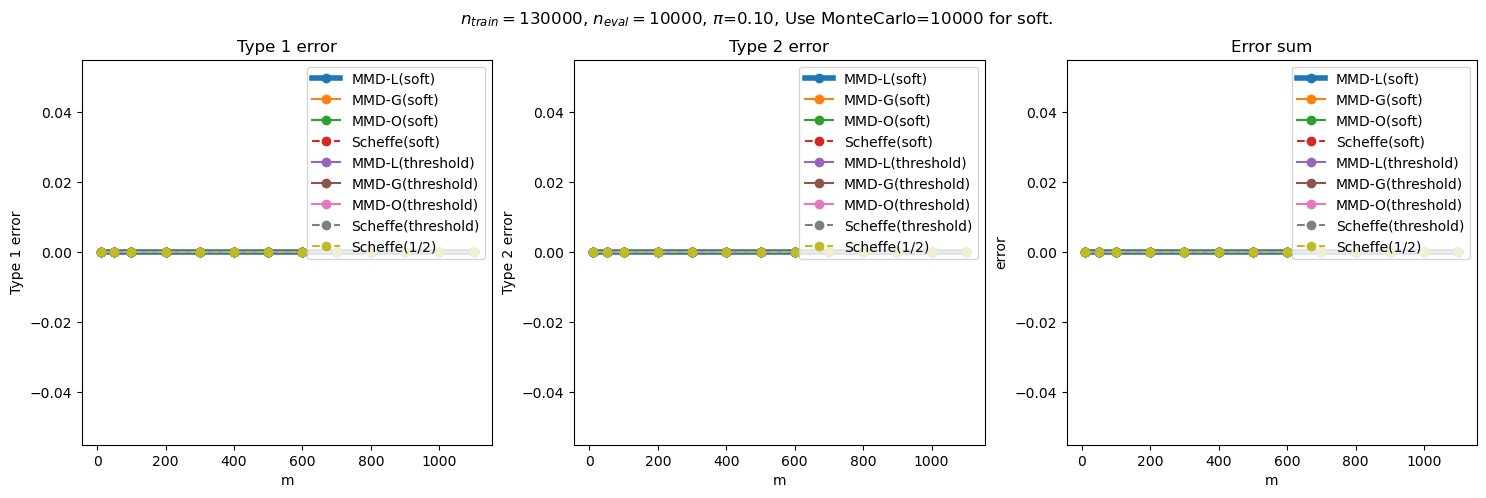

In [ ]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
plt.title('Type 1 error')
plt.plot(ms, type1_error_dict['MMD-L(soft)'], label='MMD-L(soft)', marker='o', linewidth=4)
plt.plot(ms, type1_error_dict['MMD-G(soft)'], label='MMD-G(soft)', marker='o')
plt.plot(ms, type1_error_dict['MMD-O(soft)'], label='MMD-O(soft)', marker='o')
plt.plot(ms, type1_error_dict['Scheffe(soft)'], label='Scheffe(soft)', marker='o', linestyle='--')
plt.plot(ms, type1_error_dict['MMD-L(threshold)'], label='MMD-L(threshold)', marker='o')
plt.plot(ms, type1_error_dict['MMD-G(threshold)'], label='MMD-G(threshold)', marker='o')
plt.plot(ms, type1_error_dict['MMD-O(threshold)'], label='MMD-O(threshold)', marker='o')
plt.plot(ms, type1_error_dict['Scheffe(threshold)'], label='Scheffe(threshold)', marker='o', linestyle='--')
plt.plot(ms, type1_error_dict['Scheffe(1/2)'], label='Scheffe(1/2)', marker='o', linestyle='--')
plt.legend()
plt.xlabel('m')
plt.ylabel('Type 1 error')

plt.subplot(1,3,2)
plt.title('Type 2 error')
plt.plot(ms, type2_error_dict['MMD-L(soft)'], label='MMD-L(soft)', marker='o', linewidth=4)
plt.plot(ms, type2_error_dict['MMD-G(soft)'], label='MMD-G(soft)', marker='o')
plt.plot(ms, type2_error_dict['MMD-O(soft)'], label='MMD-O(soft)', marker='o')
plt.plot(ms, type2_error_dict['Scheffe(soft)'], label='Scheffe(soft)', marker='o', linestyle='--')
plt.plot(ms, type2_error_dict['MMD-L(threshold)'], label='MMD-L(threshold)', marker='o')
plt.plot(ms, type2_error_dict['MMD-G(threshold)'], label='MMD-G(threshold)', marker='o')
plt.plot(ms, type2_error_dict['MMD-O(threshold)'], label='MMD-O(threshold)', marker='o')
plt.plot(ms, type2_error_dict['Scheffe(threshold)'], label='Scheffe(threshold)', marker='o', linestyle='--')
plt.plot(ms, type2_error_dict['Scheffe(1/2)'], label='Scheffe(1/2)', marker='o', linestyle='--')
plt.legend()
plt.xlabel('m')
plt.ylabel('Type 2 error')

plt.subplot(1,3,3)
plt.title('Error sum')
plt.plot(ms, type1_error_dict['MMD-L(soft)']+type2_error_dict['MMD-L(soft)'], label='MMD-L(soft)', marker='o', linewidth=4)
plt.plot(ms, type1_error_dict['MMD-G(soft)']+type2_error_dict['MMD-G(soft)'], label='MMD-G(soft)', marker='o')
plt.plot(ms, type1_error_dict['MMD-O(soft)']+type2_error_dict['MMD-O(soft)'], label='MMD-O(soft)', marker='o')
plt.plot(ms, type1_error_dict['Scheffe(soft)']+type2_error_dict['Scheffe(soft)'], label='Scheffe(soft)', marker='o', linestyle='--')
plt.plot(ms, type1_error_dict['MMD-L(threshold)']+type2_error_dict['MMD-L(threshold)'], label='MMD-L(threshold)', marker='o')
plt.plot(ms, type1_error_dict['MMD-G(threshold)']+type2_error_dict['MMD-G(threshold)'], label='MMD-G(threshold)', marker='o')
plt.plot(ms, type1_error_dict['MMD-O(threshold)']+type2_error_dict['MMD-O(threshold)'], label='MMD-O(threshold)', marker='o')
plt.plot(ms, type1_error_dict['Scheffe(threshold)']+type2_error_dict['Scheffe(threshold)'], label='Scheffe(threshold)', marker='o', linestyle='--')
plt.plot(ms, type1_error_dict['Scheffe(1/2)']+type2_error_dict['Scheffe(1/2)'], label='Scheffe(1/2)', marker='o', linestyle='--')
plt.legend()
plt.xlabel('m')
plt.ylabel('error')

title = '$n_{train}=%d$'%n_train + ', $n_{eval}=%d$'%n_eval + ', $\pi$=%.2f'%0.1 + ', Use MonteCarlo=%d for soft.'%MonteCarlo
plt.suptitle(title)